**Submitted by `Qi` on `9th May`**

# Optimization Exercises

This notebook was written by Selin Ataç and edited by Dr. Léa Ricard (lea.ricard@epfl.ch) for the Optimization and Simulation course at EPFL (https://edu.epfl.ch/studyplan/en/doctoral_school/civil-and-environmental-engineering/coursebook/optimization-and-simulation-MATH-600). 

Please contact before distributing or reusing the material below.


## Table of Contents
* [Travelling Salesman Problem](#Travelling-Salesman-Problem)
    * [Problem definition and encoding](#Problem-definition)
    * [Implementation: The core functionality](#Implementation)
* [Optimization Algorithms](#Optimization-algorithms)
    * [Exercise 1: Full enumeration](#Exercise-1:-Full-enumeration)
    * [Exercise 2: Greedy algorithm](#Exercise-2:-Greedy-algorithm)
    * [Exercise 3: Local search](#Exercise-3:-Local-search)
    * [Exercise 4: Variable Neighborhood Search](#Exercise-4:-Variable-Neighborhood-Search)
    * [Exercise 5: Simulated annealing](#Exercise-5:-Simulated-annealing)
* [Testing the optimization algorithms and solution profiling](#Testing-the-optimization-algorithms-and-solution-profiling)

## Travelling Salesman Problem

### Problem definition

- A salesman must visit $n$ cities.
- Every city must be visited exactly once.
- The salesman starts and ends the trip at their home city.
- The total trip length is assumed to be the cost of the travel.

### Objective

What sequence of cities minimizes the travel cost?

### Problem encoding

We consecutively number the cities: $0,..., n$

We encode the solutions as $x=(x_0, x_1,..., x_n, x_0)$ where

- $x_0$ is the index of the home city,
- $x_i$ is the index of the $i^{th}$ city visited along the way, and
- $x_n$ is the index of the last city visited before returning home.

### Implementation

#### The required python libraries
You will use the following python libraries in this exercise: `numpy`, `plotly`. Install it using `pip` on your command line:

    pip install numpy plotly

or if you are using conda:

    conda install numpy
    conda install -c plotly plotly

In [1]:
import numpy as np
import pandas as pd
from numpy import sqrt
import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import time
import timeit
import math

from numpy.random import Generator, PCG64 
from plotly.subplots import make_subplots

### The core functionality

Before we optimize the path of the salesman, we need to construct several functions to help us simulate and display the path of the salesman.

Begin by implementing a function for simulating city locations on an x-y grid. 
At the end of this step, you will be able to generate a plot of cities on an x-y coordinate plot, path of the salesman, and a list of tuples representing the location of the cities.

1. Implement a function `simulate_cities(rg, n_cities)` which takes as input: 
  - `rg` : a numpy random generator object with a specified seed value
  - `n_cities`: an integer for the number of cities to generate
 
 The return of the function should be a dictionary of tuples, e.g., `{0: (x0,y0), 1: (x1,y1), ..., n: (xn,yn)}`

In [2]:
def simulate_cities(rg, n_cities):
    """Function to implement

    Args:
        rg (Generator object): a numpy random generator object with a specified seed value
        n_cities (int) : an integer for the number of cities to generate
        
    Returns:
        cities (dict): data structure that contains supplementary 
            information about the problem, in particular the xy-coordinates of the 
            cities.
    
    Example:
        rg = Generator(PCG64(42069))
        simulate_cities(rg, 2)
        >>> {0: (2.4, 1.4), 1: (0.2, 3.5)}   
    """  
    city_numbers = np.arange(0, n_cities)
    
    # Generate random coordinates
    latitudes = rg.uniform(-10, 10, n_cities)
    longitudes = rg.uniform(-10, 10, n_cities)
    
    # Create dictionary with city number as key and (latitude, longitude) as values
    city_dict = {int(city_number): (lat, lon) for city_number, lat, lon in zip(city_numbers, latitudes, longitudes)}
    
    return city_dict

    
    return cities

#### Test the function `simulate_cities(rg, n_cities)`

In [3]:
rg = Generator(PCG64(42069)) # set your own unique seed number
simulate_cities(rg, 10)

{0: (8.957992931255298, 6.145462998601513),
 1: (-4.051794994232698, -2.954464632658227),
 2: (-8.563950554125439, 3.971903381746774),
 3: (-3.4098360921227977, 4.714237637622221),
 4: (1.1888287068599457, 5.4031250410225535),
 5: (7.2693494728479955, 5.811856448415467),
 6: (4.426959649314458, -2.021881162802586),
 7: (3.8284888858918613, -3.1354534524581386),
 8: (0.8170665196854472, 1.50927417315501),
 9: (-0.9291013401462127, 2.777711173921084)}

2. Implement a function `draw_salesman(path, cities)` which takes as input:
  - `path`: a list of integers which represents the sequence of cities visited, e.g. `[0,1,3,2,4,0]` 
  - `cities`: a dictionary of city x-y coordinates, keyed by the number of the city, use the return value of the `simulate_cities()` function as example: `{0: (x0,y0), 1: (x1,y1), ..., n: (xn,yn)}`
  
 The return of the function should display a visualization of the cities visited.

In [4]:
def draw_salesman(path, cities, title="Path taken"):
    """Function to implement

    Args:
        path (list): a row vector representing the solution to be evaluated
        cities (dict): data structure that contains supplementary 
            information about the problem, in particular the xy-coordinates of the 
            cities.
        **kwargs: arbitrary keyword arguments (optional variables)
    """  
    for city in path:
        if city not in cities:
            raise ValueError(f"City ID {city} in path is not present in the cities dictionary.")

    # Extract coordinates based on the path
    x_coords = [cities[city][1] for city in path]  # longitude
    y_coords = [cities[city][0] for city in path]  # latitude
    
    # Create a plot
    plt.figure(figsize=(10, 5))
    plt.plot(x_coords, y_coords, color='b')  # Line plot connecting the cities
    plt.scatter(x_coords, y_coords, color='r', s=100) 

    # Annotate each city with its ID
    for i, city in enumerate(path):
        plt.text(x_coords[i], y_coords[i], f'{city}')

    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

#### Test the function `draw_salesman(path, cities)`

{0: (8.957992931255298, 6.145462998601513), 1: (-4.051794994232698, -2.954464632658227), 2: (-8.563950554125439, 3.971903381746774), 3: (-3.4098360921227977, 4.714237637622221), 4: (1.1888287068599457, 5.4031250410225535), 5: (7.2693494728479955, 5.811856448415467), 6: (4.426959649314458, -2.021881162802586), 7: (3.8284888858918613, -3.1354534524581386), 8: (0.8170665196854472, 1.50927417315501), 9: (-0.9291013401462127, 2.777711173921084)}


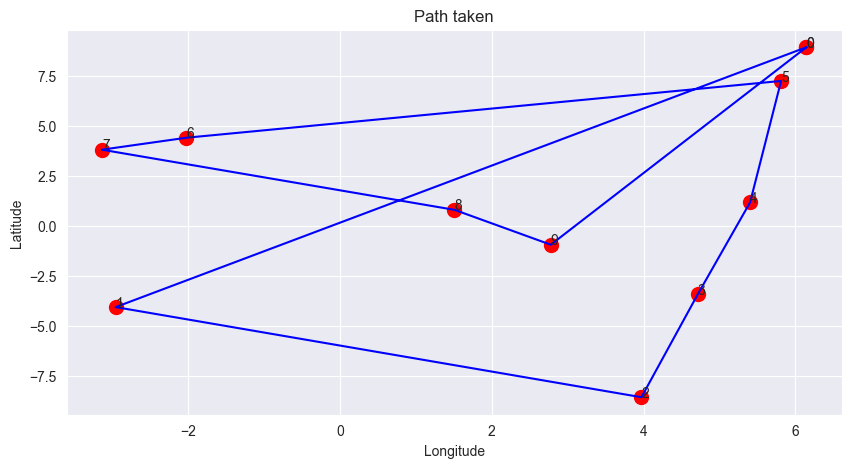

In [5]:
rg = Generator(PCG64(42069)) # set your own unique seed number
n_cities = 10
cities = simulate_cities(rg, n_cities) # simulate the list of cities
print(cities)
solution = list(range(0, n_cities)) # sample solution of the path of the salesman
solution.append(solution[0])
draw_salesman(solution, cities) # draw salesman

3. Implement a function `evaluate_city_sequence(path, cities)` which takes as input:
  - `path`: a list of integers which represents the sequence of cities visited, e.g. `[0,1,3,2,4,0]` 
  - `cities`: the dict of cities {n: (x, y)}

The return of the function should be the **total length of the travelled path**.
  
We use the Euclidean distance to calculate the distance between each city, including the distance from the final visited city back to the home city.

In [6]:
def evaluate_city_sequence(path, cities, **kwargs):
    """Function to implement

    Returns the total length of the travelled path.

    Args:
        path (list): a row vector representing the solution to be evaluated
        cities (dict): data structure that contains supplementary 
            information about the problem, in particular the xy-coordinates of the 
            cities.
        **kwargs: arbitrary keyword arguments (optional variables)
    
    Returns:
        Q (float): a scalar representing the value of a path's objective function (i.e., the total
            distance travelled)
    
    Example:
        cities = {0: (2.4, 1.4), 1: (0.2, 3.5)}
        calculated = evaluate_city_sequence([0, 1], cities)
        print(calculated)
        >>> 3.041381
    """  
   
    total_distance = 0.0

    # Calculate the distance between consecutive cities
    for i in range(len(path) - 1):
        x1, y1 = cities[path[i]]
        x2, y2 = cities[path[i+1]]
        distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        total_distance += distance
    Q = total_distance
    return Q
    

**Test the function `evaluate_city_sequence(x, cities=None, **kwargs)`** and verify that the calculation is correct.

In [7]:
def evaluate_city_sequence_test(cities={0: (0, 0), 1: (1, 1)}):
    """Very simple test
    
    Salesman starts at city zero with coordinates(0, 0), travels to city one with 
    coordinates(1, 1), and then returns to city zero.
    """

    # expected distance travelled
    expected = 2 * np.sqrt(2);
    
    # call your objective function
    calculated = evaluate_city_sequence([0, 1, 0], cities)
    
    # show your results
    results = print(
        'Expected={0:.3f}, Calculated={1:.3f}'.format(expected, calculated)
    )
    if abs(expected-calculated) < 1e-6:
        print('OK')
    else:
        print('NOT CORRECT')

evaluate_city_sequence_test()

Expected=2.828, Calculated=2.828
OK


## Optimization algorithms

### Optimize traveling salesman path

We want to optimize the path taken by a travelling salesman. 
First, implement a function `randomly_generate_new_city_seq()` that randomly generates a path sequence. This funtion will serve as a benchmark to test "smarter" algorithms.
We assume that the salesman always starts and ends in city `0`.

A very simple example is a full (random) enumeration of the cities.

In [8]:
def randomly_generate_new_city_seq(rg, path, cities=None, **kwargs):
    """Function to implement

    Returns a permutation of the row vector "path", where the first and last elements
    of "path" stay unchanged. Implement different specifications. For example:
    - exchanges two randomly selected entries of "path"

    Args:
        rg (Generator object) : a numpy random generator object with a specified seed value
        path (list): a row vector representing the current city sequence
        cities (dict, optional): data structure that contains supplementary 
            information about the problem, in particular the coordinates of the 
            cities.
        **kwargs: arbitrary keyword arguments (optional variables)
    
    Returns:
        new_path (list): a row vector with a permutation of "path", where the first and last
        elements of "new_path" are the first and last elements of "path", respectively.
    
    Example:
        path = [0, 1, 2, 3, 4, 5]
        new_path = randomly_generate_new_city_seq(path)
        print(new_path)
        >>> [0, 1, 3, 2, 4, 5]
    """   
    new_path = np.array(path.copy()) # make a copy of path
    rg.shuffle(new_path[1:-2])
    
    
    return list(new_path)
    

#### Test the function

{0: (8.957992931255298, 3.8545514964456125), 1: (-4.051794994232698, 1.4836604254332215), 2: (-8.563950554125439, 9.785581820045081), 3: (-3.4098360921227977, 7.150065392771985), 4: (1.1888287068599457, 7.1272514139082155), 5: (7.2693494728479955, -6.917691251019704), 6: (4.426959649314458, 6.53685633988292), 7: (3.8284888858918613, -9.749981714596803), 8: (0.8170665196854472, 1.7292924805675653), 9: (-0.9291013401462127, 3.461318486638481), 10: (6.145462998601513, -5.086581450178443), 11: (-2.954464632658227, 5.389442303999903), 12: (3.971903381746774, -8.03105291428946), 13: (4.714237637622221, 4.006337082014724), 14: (5.4031250410225535, 4.154748540984567), 15: (5.811856448415467, -1.7322862985884395), 16: (-2.021881162802586, -5.205300708428753), 17: (-3.1354534524581386, -0.641275945077), 18: (1.50927417315501, -8.792832592716014), 19: (2.777711173921084, 7.685417795115438)}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0]
[0, 9, 7, 8, 4, 5, 18, 3, 11, 17,

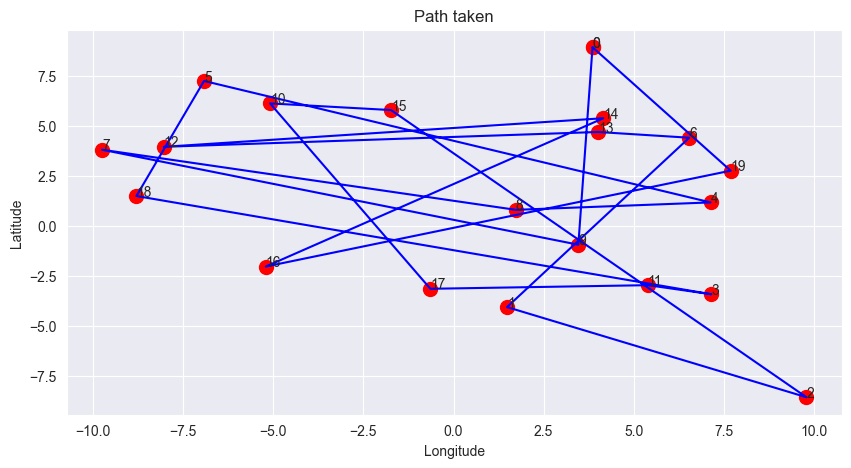

In [9]:
rg = Generator(PCG64(42069)) # set your own unique seed number
n_cities = 20
cities = simulate_cities(rg, n_cities)
print(cities)
path = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0]
print(path)
rg = Generator(PCG64(42070))
path = randomly_generate_new_city_seq(rg, path)
print(path)
draw_salesman(path, cities)

### Algorithms

Notice in our sample solution, it was not ideal and the salesman's path criss-crossed. Our goal is to minimize the total distance travelled by the salesman, while visiting all the cities.

We can use the total path travelled as our **objective function**. Recall the function `evaluate_city_sequence()`, this is our objective function.

Now let us integrate `evaluate_city_sequence()` in the **full enumeration** algorithm. This is a simple trial and error method.

### Exercise 1: Full enumeration

Functions to implement:

`full_enumeration()`

Calculate the computational time and limitations of the full enumeration.

What is the maximum problem size (number of cities) that you could solve with this approach?

In [10]:
import itertools
from itertools import permutations

In [11]:
def evaluate_city_sequence(path, cities):
    """Calculate the total distance traveled for a path, including returning to the start."""
    total_distance = 0.0
    # Calculate distance for the path
    for i in range(len(path) - 1):
        x1, y1 = cities[path[i]]
        x2, y2 = cities[path[i+1]]
        distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        total_distance += distance
    # Add distance from the last city back to the first city
    x1, y1 = cities[path[-1]]
    x2, y2 = cities[path[0]]
    total_distance += math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return total_distance

def full_enumeration(cities, **kwargs):
    """Function to implement

    Enumeratesall possible permutations of the cities and return the best solution minimizing distance travelled.

    Args:
        cities (dict, optional): data structure that contains supplementary 
            information about the problem, in particular the xy-coordinates of the 
            cities.
        **kwargs: arbitrary keyword arguments (optional variables)
    
    Returns:
        best_path (list): a row vector representing the minimum cost city sequence
        best_path_cost (float): a scalar representing the objective function value of the best path
    
    """  
    
    city_ids = list(cities.keys())
    start_city = city_ids.pop(0)  # Remove the start city (city 0) from the list to fix the start and end points

    best_path = [start_city]
    best_path_cost = float('inf')

    # Generate all possible permutations of the remaining city IDs
    for perm in itertools.permutations(city_ids):
        # Form the full path by adding the start city to the beginning and end
        full_path = [start_city] + list(perm) + [start_city]
        # Calculate the cost of this path
        path_cost = evaluate_city_sequence(full_path, cities)
        # Check if this path is better than what we found so far
        if path_cost < best_path_cost:
            best_path_cost = path_cost
            best_path = full_path

    return best_path, best_path_cost


best solution: [0, 5, 4, 8, 9, 3, 2, 1, 7, 6, 0]
distance travelled: 48.99273905145975
Computing time: 0.9720399379730225 seconds


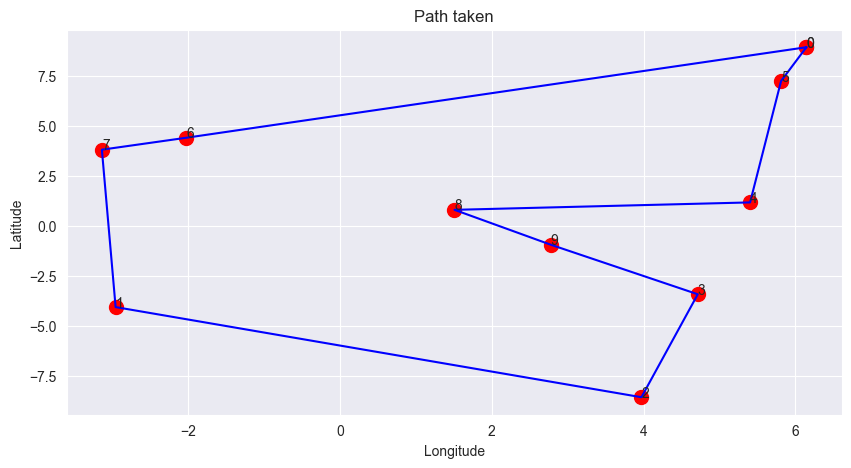

In [12]:
# Test
rg = Generator(PCG64(42069)) # set your own unique seed number
n_cities = 10
cities = simulate_cities(rg, n_cities) # simulate the list of cities
start_time = time.time()  # Record start time
solution, distance = full_enumeration(cities)
end_time = time.time()  # Record end time
print("best solution:", solution)
print("distance travelled:", distance)
print("Computing time:", end_time - start_time, "seconds")

draw_salesman(solution, cities)

### Exercise 2: Greedy algorithm

**Principles:**
- At each step, a decision is made that depends on the previous decision.
- It is easy to implement, but may generate poor solutions.

**The algorithm:**
1. Start from home city
2. Select the next closest city
3. Repeat 2 until all cities have been visited
4. Return to home city

Implement this algorithm in your own Python notebook and test it out. Try to reuse portions of the code in the first exercise.

The function to implement:

`greedy()`

Calculate the computational time.

Profile your greedy algorithm and compare it with the full enumeration algorithm. What do you observe? Explain the pros and cons of each method.

In [40]:
def calculate_distance(city1, city2):
    """Calculate the Euclidean distance between two cities."""
    return math.sqrt((city2[0] - city1[0])**2 + (city2[1] - city1[1])**2)

def greedy(cities, **kwargs):
    """Function to implement

    Returns a good solution that minimizes distance travelled.

    Args:
        cities (dict, optional): data structure that contains supplementary 
            information about the problem, in particular the xy-coordinates of the 
            cities.
        **kwargs: arbitrary keyword arguments (optional variables)
    
    Returns:
        path (list): a row vector representing a feasible city sequence
        path_cost (float): a scalar representing the objective function value of the path outputted
    
    """ 
    
    start_city = list(cities.keys())[0]  # Start from the first city in the dictionary
    unvisited = set(cities.keys())
    path = [start_city]
    unvisited.remove(start_city)
    current_city = start_city

    # Select the next closest city until all cities have been visited
    while unvisited:
        next_city = min(unvisited, key=lambda city: calculate_distance(cities[current_city], cities[city]))
        path.append(next_city)
        unvisited.remove(next_city)
        current_city = next_city

    # Return to the home city
    path.append(start_city)
    path_cost = sum(calculate_distance(cities[path[i]], cities[path[i+1]]) for i in range(len(path) - 1))

    return path, path_cost
        

best solution: [0, 2, 7, 4, 8, 6, 3, 5, 1, 9, 0]
distance travelled: 59.71058436611854
Computing time: 6.580352783203125e-05 seconds


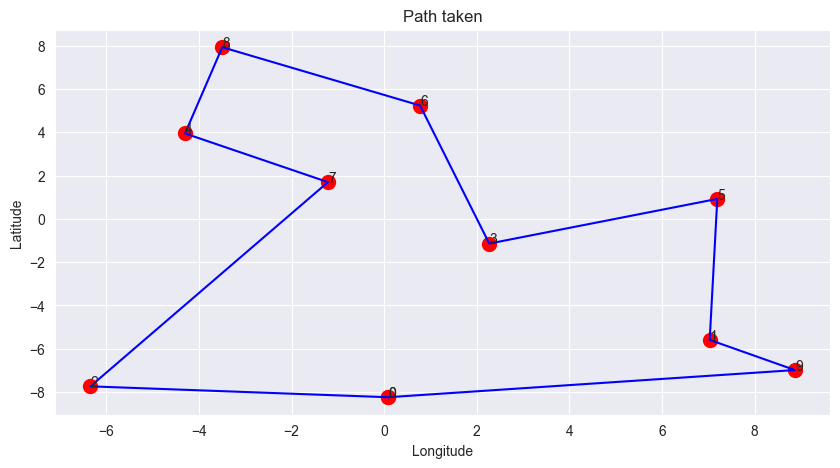

In [41]:
# Test
rg = Generator(PCG64(2023)) # set your own unique seed number
n_cities = 10
cities = simulate_cities(rg, n_cities)
start_time = time.time()  # Record start time
solution, distance = greedy(cities) # new input parameter K
end_time = time.time()  # Record end time
print("best solution:", solution)
print("distance travelled:", distance)
print("Computing time:", end_time - start_time, "seconds")

draw_salesman(solution, cities)

### Exercise 3: Local search

A local search algorithm iteratively explores neighboring solutions to improve upon an initial candidate, aiming to find the optimal solution by making incremental changes.

**Input**: 

$V(x)$: Neighbourhood structure, where $V(x)$ is the set of feasible neighbors of $x$. Use the 2-OPT neighborhod method.

**Initialization**: 
- $x_0$: use the outcome of the greedy algorithm

**Iterations**: 
- At each iteration $k$, consider the neighbors in $V(x_k)$ one at a time
- For each $y \in V(x_k)$, if $f(y) \leq f(x_k)$, then $x_{k+1} = y$
- If $f(y) > f(x_k), \forall y \in V(x_k)$, $x_k$ is a local minimum. Stop.

Functions to implement:

`twoOPT_neighborhood()`

`local_search()`

Calculate the computational time.

In [76]:
def twoOPT_neighborhood(x, cities=None, **kwargs):
    """Function to implement

    Returns the 2-OPT neighborhoods of a path. 

    Args:
        x : a row vector representing the current city sequence
        cities (dict, optional): data structure that contains supplementary 
            information about the problem, in particular the xy-coordinates of the 
            cities.
        **kwargs: arbitrary keyword arguments (optional variables)
    
    Returns:
        neighbors (numpy matrix): a matrix representing all paths in the neighborhood of x
    
    """
    neighbors = []
    n = len(x)
    for i in range(1, n - 2):
        for j in range(i + 1, n - 1):
            new_route = x[:i] + x[i:j+1][::-1] + x[j+1:]
            neighbors.append(new_route)
    return neighbors
    
def calculate_total_distance(path, cities):
    """Calculate the total distance for a given path."""
    total_distance = sum(math.sqrt((cities[path[i]][0] - cities[path[i+1]][0])**2 + 
                                   (cities[path[i]][1] - cities[path[i+1]][1])**2)
                         for i in range(len(path) - 1))
    return total_distance 

def local_search(cities, iterations=1000):
    """Function to implement

     Returns a local minimum to the traveling salesman problem

    Args:
        cities (dict, optional): data structure that contains supplementary 
            information about the problem, in particular the xy-coordinates of the 
            cities.
        **kwargs: arbitrary keyword arguments (optional variables)
    
    Returns:
        x:  a row vector representing a local minimum city sequence
        objValue_x: a scalar representing the objective function value of the path outputted
    
    """
    city_ids = sorted(cities.keys())
    # Start at city 0, visit all cities once, then return to city 0
    current_path = [0] + [city for city in city_ids if city != 0] + [0]
    current_cost = calculate_total_distance(current_path, cities)
    iteration_count = 0

    while iteration_count < iterations:
        improving = False
        neighbors = twoOPT_neighborhood(current_path)
        for neighbor in neighbors:
            neighbor_cost = calculate_total_distance(neighbor, cities)
            if neighbor_cost < current_cost:
                current_path = neighbor
                current_cost = neighbor_cost
                improving = True
                break  # Exit early for the first improvement found
        if not improving:
            break  # Exit the while loop if no improvement
        iteration_count += 1

    x= current_path
    objValue_x = current_cost
    
    return x, objValue_x
    

#### Test the function

best solution: [0, 9, 1, 5, 3, 6, 8, 4, 7, 2, 0]
distance travelled: 59.71058436611854
Computing time: 0.0005359649658203125 seconds


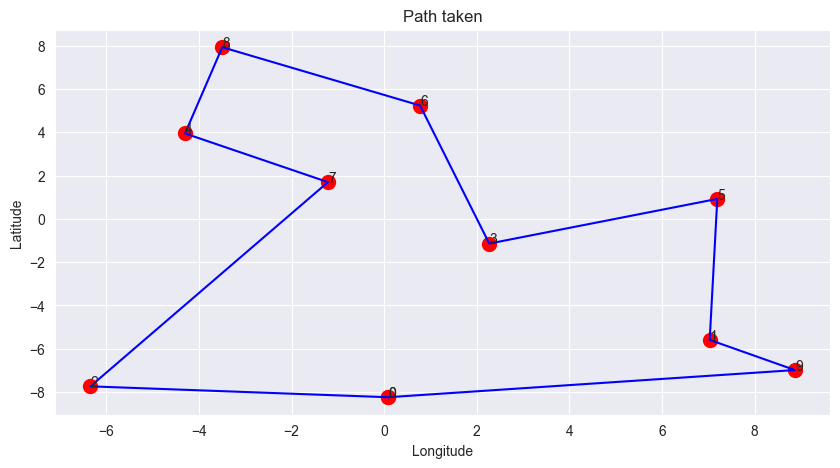

In [77]:
# Test
rg = Generator(PCG64(2023)) # set your own unique seed number
n_cities = 10
cities = simulate_cities(rg, n_cities)
path = [0,1,2,3,4,5,6,7,8,9,0]
start_time = time.time()  # Record start time
solution, distance = local_search(cities,iterations=1000)
end_time = time.time()  # Record end time
print("best solution:", solution)
print("distance travelled:", distance)
print("Computing time:", end_time - start_time, "seconds")

draw_salesman(solution, cities)

### Exercise 4: Variable Neighborhood Search

In the variable neighborhood search, we consider several neighborhood structures.

When a local optimum has been found for a given neighborhood structure, continue with another structure.

**Input**: 

$V_1, V_2, ..., V_K$: Neighbourhood structures
where $K$ is the total number of neighborhood structures

**Initialization**: 
- $x_c \leftarrow x_0$ (initial solution)
- $k\leftarrow 0$ 

Functions to implement:

`neighborhood_1()`

`neighborhood_2()`

`neighborhood_...()`

`neighborhood_k()`

`variable_neighborhood_search()`

Calculate the computational time.

In [78]:
import random
def neighborhood_1(x, cities=None, **kwargs):
    """Function to implement

    Select a neighborhood structure of your choice. This function returns the neighbors of a path. 

    Args:
        x : a row vector representing the current city sequence
        cities (dict, optional): data structure that contains supplementary 
            information about the problem, in particular the xy-coordinates of the 
            cities.
        **kwargs: arbitrary keyword arguments (optional variables)
    
    Returns:
        neighbors (numpy matrix): a matrix representing all paths in the neighborhood of x
    """
    neighbors = []
    n = len(x)
    for i in range(1, n - 2):
        for j in range(i + 1, n - 1):
            new_route = x[:i] + x[i:j+1][::-1] + x[j+1:]
            neighbors.append(new_route)

    return neighbors

def neighborhood_2(x):
    """Generates all 3-OPT neighbors of a given tour."""
    neighbors = []
    n = len(x)
    for i in range(1, n-3):
        for j in range(i+1, n-2):
            for k in range(j+1, n-1):
                # 3-OPT swap: breaking and reconnecting three edges
                new_route = x[:i] + x[i:j+1][::-1] + x[j+1:k+1][::-1] + x[k+1:]
                neighbors.append(new_route)
    return neighbors
    

def variable_neighborhood_search(cities,iterations=600, **kwargs):
    """Function to implement

     Returns a good feasible solution to the traveling salesman problem

    Args:
        cities (dict, optional): data structure that contains supplementary 
            information about the problem, in particular the xy-coordinates of the 
            cities.
        iterations (int): maximum number of iterations of the algorithm
        **kwargs: arbitrary keyword arguments (optional variables)
    
    Returns:
        x:  a row vector representing a local minimum city sequence
        objValue_x: a scalar representing the objective function value of the path outputted
    
    """
    city_ids = sorted(cities.keys())
    # Start at city 0, visit all cities once, then return to city 0
    current_solution = [0] + [city for city in city_ids if city != 0] + [0]
    neighborhood_functions = [neighborhood_1, neighborhood_2]  # List of neighborhood structures
    current_cost = calculate_total_distance(current_solution, cities)

    for iteration in range(iterations):
        k = 0
        while k < len(neighborhood_functions):
            neighbors = neighborhood_functions[k](current_solution)
            candidate_solution = random.choice(neighbors)
            candidate_cost = calculate_total_distance(candidate_solution, cities)
            if candidate_cost < current_cost:
                current_solution = candidate_solution
                current_cost = candidate_cost
                k = 0  # Move back to the first neighborhood structure
            else:
                k += 1  # Move to the next neighborhood structure
    x=current_solution
    objValue_x = current_cost

                    
    return x, objValue_x
    

#### Test the function

best solution: [0, 2, 7, 4, 8, 6, 3, 5, 1, 9, 0]
distance travelled: 59.71058436611854
Computing time: 0.03262901306152344 seconds


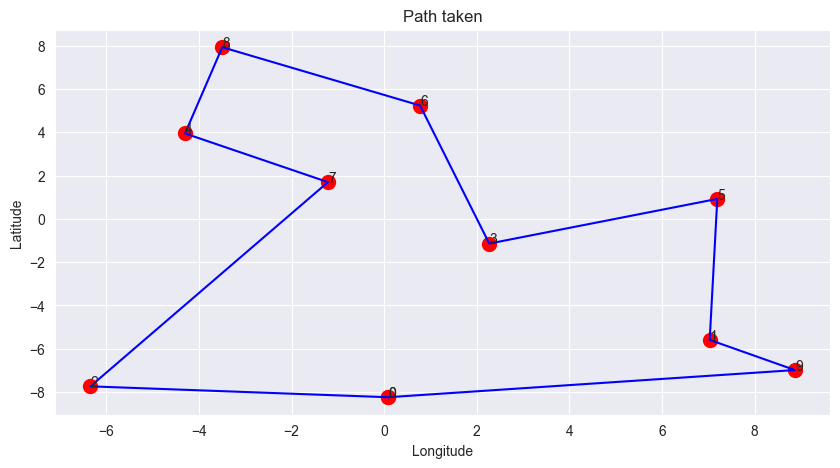

In [79]:
# Test
rg = Generator(PCG64(2023)) # set your own unique seed number
n_cities = 10
cities = simulate_cities(rg, n_cities)
path = [0,1,2,3,4,5,6,7,8,9,0]

start_time = time.time()  # Record start time
solution, distance = variable_neighborhood_search(cities, iterations=600)
end_time = time.time()  # Record end time
print("best solution:", solution)
print("distance travelled:", distance)
print("Computing time:", end_time - start_time, "seconds")

draw_salesman(solution, cities)

### Exercise 5: Simulated annealing

In simulated annealing, we consider solutions that are not better from the current best solution with a probability.

***
- Select a random solution $y \in V(x_k)$
- If $f(y) \leq f(x_k)$ 
    - $x_{k+1} = y$
- Else 
    - $x_{k+1} = y$ with probability $e^{-\frac{f(y)-f(x_k)}{T}}$ with T > 0
***

To deal with that, one can draw $r$ from $uniform(0,1)$ distribution and accept $y$ if $e^{-\frac{f(y)-f(x_k)}{T}} > r$.

Functions to implement:

`temperature_upt()`

`simulated_annealing()`

Calculate the computational time.

In [80]:
def temperature_upt(max_t_changes, t_changes, avg_inc_obj, accep_init, accep_final):
    if t_changes == 0:
        return -avg_inc_obj / math.log(accep_init)
    elif t_changes >= max_t_changes:
        return -avg_inc_obj / math.log(accep_final)
    else:
        t_init = -avg_inc_obj / math.log(accep_init)
        t_final = -avg_inc_obj / math.log(accep_final)
        return t_init + (t_final - t_init) * (t_changes / max_t_changes)


def simulated_annealing(cities, iterations=600, **kwargs):
    """Function to implement

     Returns a good feasible solution to the traveling salesman problem

    Args:
        cities (dict, optional): data structure that contains supplementary 
            information about the problem, in particular the xy-coordinates of the 
            cities.
        iterations (int): maximum number of iterations of the algorithm
        **kwargs: arbitrary keyword arguments (optional variables)
    
    Returns:
        x:  a row vector representing a local minimum city sequence
        objValue_x: a scalar representing the objective function value of the path outputted
    """
    city_ids = sorted(cities.keys())
    # Start at city 0, visit all cities once, then return to city 0
    current_solution = [0] + [city for city in city_ids if city != 0] + [0]
    current_cost = calculate_total_distance(current_solution, cities)
    
    max_t_changes = int(0.6 * iterations)
    num_itr_temp = int(0.4 * iterations)
    avg_inc_obj = 0.5
    accep_init = 0.999
    accep_final = 0.00001

    t_changes = 0
    while t_changes < max_t_changes:
        temperature = temperature_upt(max_t_changes, t_changes, avg_inc_obj, accep_init, accep_final)
        for _ in range(num_itr_temp):
            # Select a neighbor (2-OPT swap)
            neighbor = random.choice(neighborhood_1(current_solution))
            neighbor_cost = calculate_total_distance(neighbor, cities)

            # Calculate the acceptance probability
            if neighbor_cost < current_cost:
                current_solution = neighbor
                current_cost = neighbor_cost
            else:
                delta = neighbor_cost - current_cost
                probability = math.exp(-delta / temperature)
                if random.random() < probability:
                    current_solution = neighbor
                    current_cost = neighbor_cost
        t_changes += 1
        x= current_solution 
        objValue_x = current_cost
    
    return x, objValue_x
        
    

#### Test the function

best solution: [0, 5, 4, 3, 9, 1, 2, 8, 7, 6, 0]
distance travelled: 56.2452143386336
Computing time: 1.0951619148254395 seconds


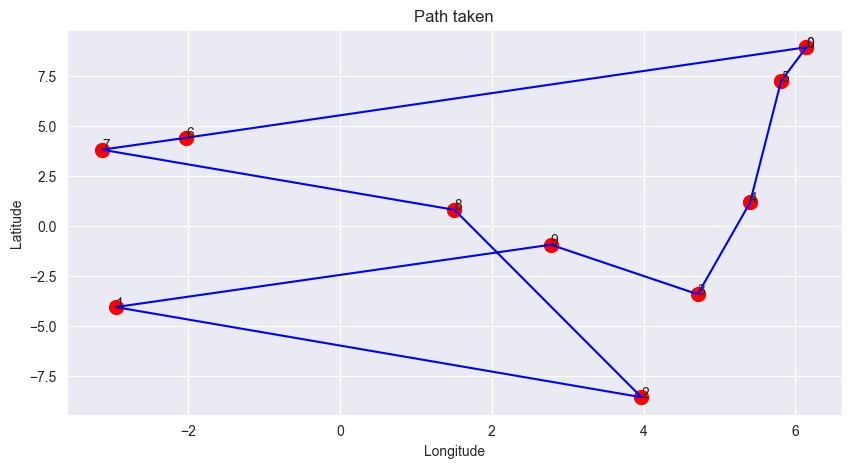

In [81]:
# Test
rg = Generator(PCG64(42069)) # set your own unique seed number
n_cities = 10
cities = simulate_cities(rg, n_cities)
start_time = time.time()  # Record start time
path = [0,1,2,3,4,5,6,7,8,9,0]
solution, distance = simulated_annealing(cities,initial_solution=path, iterations = 600)
end_time = time.time()  # Record end time
print("best solution:", solution)
print("distance travelled:", distance)
print("Computing time:", end_time - start_time, "seconds")

draw_salesman(solution, cities)

## Testing the optimization algorithms and solution profiling

### Testing
#### Test your optimization functions using `optimization_TSP_test()`

{0: (-8.238910904744312, 0.08281287363965717), 1: (-5.591199113254717, 7.02773391422415), 2: (-7.736588915352263, -6.3456514513032), 3: (-1.140663304367596, 2.267544285940737), 4: (3.9466284320470137, -4.302256814942666), 5: (0.9236429029263711, 7.192207952860635), 6: (5.23721003559498, 0.7740840752445735), 7: (1.6980256616885079, -1.2155425146578445), 8: (7.930530218523785, -3.498058801136903), 9: (-6.983866244012273, 8.868317207137093)}
initial solution: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0]
inital distance travelled: 98.699572949129


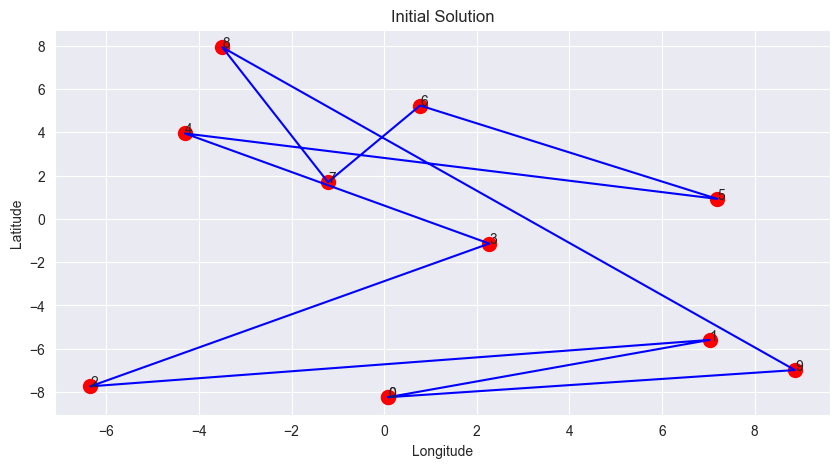

Full Enumeration
-----------
best solution: [0, 2, 4, 8, 6, 7, 3, 5, 1, 9, 0]
distance travelled: 59.0161093276416
Computing time: 1.0013058185577393 seconds


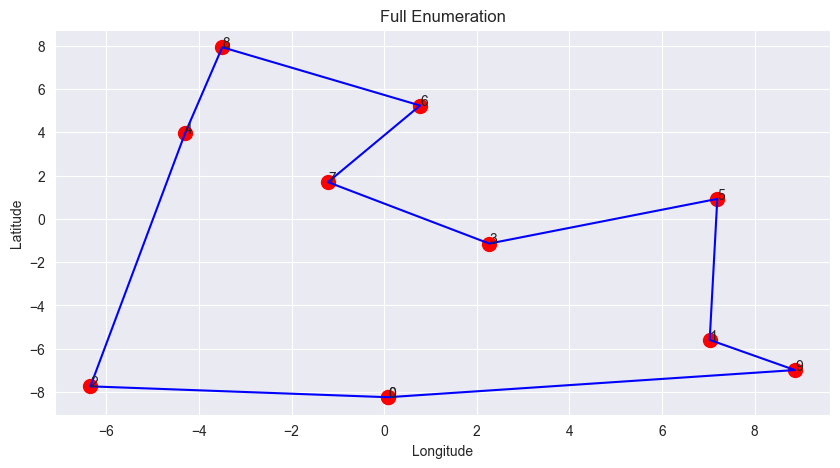

Greedy algorithm
-----------
best solution: [0, 2, 7, 4, 8, 6, 3, 5, 1, 9, 0]
distance travelled: 59.71058436611854
Computing time: 4.315376281738281e-05 seconds


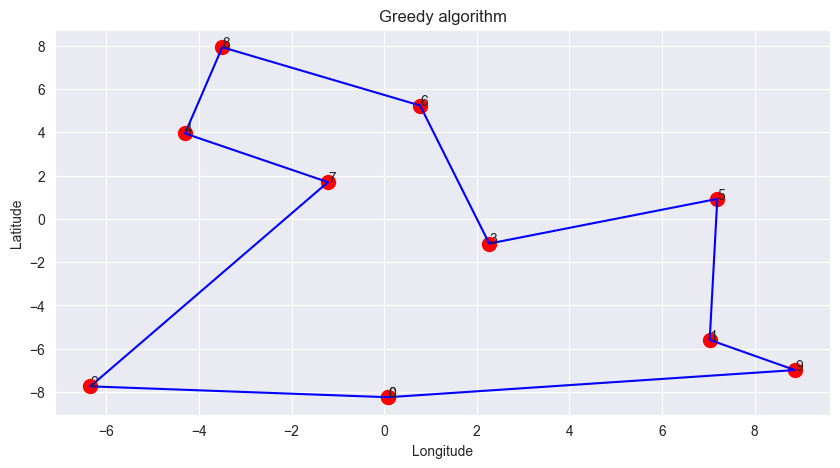

Local search algorithm
-----------
best solution: [0, 9, 1, 5, 3, 6, 8, 4, 7, 2, 0]
distance travelled: 59.71058436611854
Computing time: 0.0005397796630859375 seconds


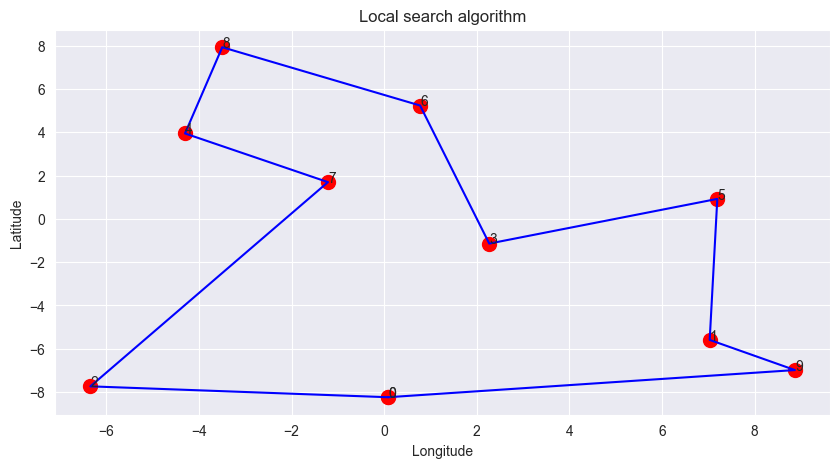

Variable neighborhood search algorithm
-----------
best solution: [0, 9, 1, 5, 6, 8, 4, 7, 3, 2, 0]
distance travelled: 60.15617359812699
Computing time: 0.028010845184326172 seconds


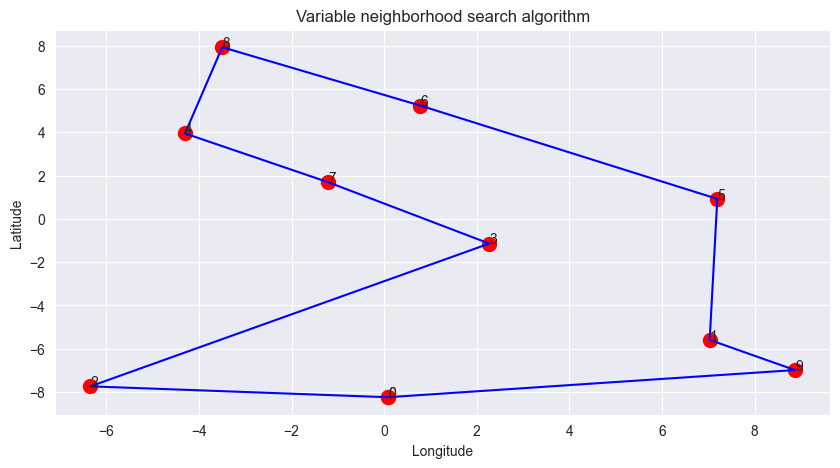

Simulated annealing algorithm
-----------
best solution: [0, 2, 4, 8, 6, 7, 3, 5, 1, 9, 0]
distance travelled: 59.0161093276416
Computing time: 0.9769010543823242 seconds


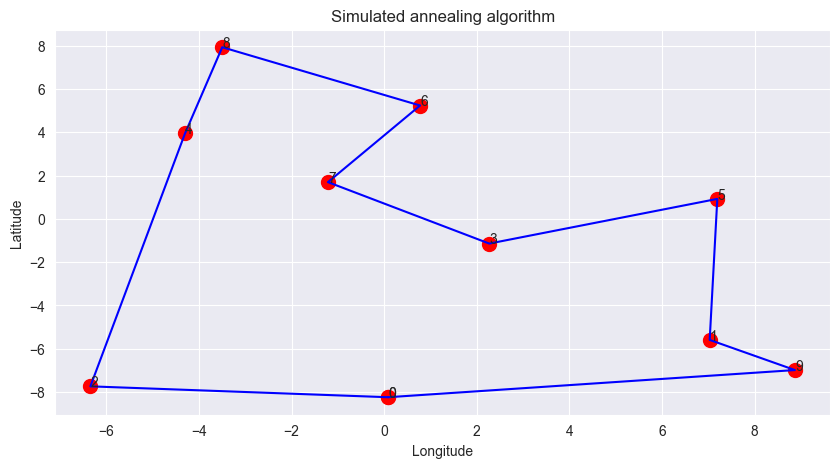

In [82]:
# Run the optimization by reusing the functions simulateCities(), drawSalesman(), evaluate()

def optimization_TSP_test(rg, n_cities=15, iterations=600):
    cities = simulate_cities(rg, n_cities)
    inital_solution = list(range(len(cities))) + [0]
    print(cities)
    print("initial solution:", inital_solution)
    print("inital distance travelled:", evaluate_city_sequence(inital_solution, cities))
    draw_salesman(inital_solution, cities, "Initial Solution") # show the inital solution
    
    algorithms = {
    'Full Enumeration': full_enumeration,
    'Greedy algorithm': greedy,
    'Local search algorithm': local_search,
    'Variable neighborhood search algorithm': variable_neighborhood_search,
    'Simulated annealing algorithm': simulated_annealing
    }
    
    for algorithm_name, algorithm in algorithms.items():
        print(algorithm_name + "\n-----------")
        start_time = time.time()  # Record start time
        solution, distance = algorithm(cities, iterations=iterations)
        end_time = time.time()  # Record end time
        print("best solution:", solution)
        print("distance travelled:", distance)
        print("Computing time:", end_time - start_time, "seconds")
        draw_salesman(solution, cities, algorithm_name)

# run all
rg = Generator(PCG64(2023)) 
optimization_TSP_test(rg, n_cities=10, iterations=600)